In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('../learnMSA')
from learnMSA import msa_hmm
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import time

In [2]:
train_filename = "data/homfam/train/egf.fasta"
out_filename = "results/egf_test.fasta"
num_models = 1
config = msa_hmm.config.make_default(num_models)
alignment = msa_hmm.align.run_learnMSA(train_filename, out_filename, config, verbose=True)

Training of 1  models on file egf.fasta
Configuration:
num_models : 1 , transitioner : ProfileHMMTransitioner(transition_init={'begin_to_match': <learnMSA.msa_hmm.Initializers.EntryInitializer object at 0x7f09746f4bb0>, 'match_to_end': <learnMSA.msa_hmm.Initializers.ExitInitializer object at 0x7f09746f4e50>, 'match_to_match': <learnMSA.msa_hmm.Initializers.MatchTransitionInitializer object at 0x7f09746f4ac0>, 'match_to_insert': <learnMSA.msa_hmm.Initializers.MatchTransitionInitializer object at 0x7f09746f4d90>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f09746f4130>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f09746f4e80>, 'match_to_delete': <learnMSA.msa_hmm.Initializers.MatchTransitionInitializer object at 0x7f09767a4e20>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f09767a4d60>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f09767293a0>, '

In [3]:
fasta_file = msa_hmm.fasta.Fasta(train_filename)
batch_gen = msa_hmm.train.DefaultBatchGenerator(fasta_file, alignment.num_models)
indices = tf.range(fasta_file.num_seq, dtype=tf.int64)

In [6]:
p = msa_hmm.align.get_state_expectations(fasta_file,
                                batch_gen,
                                indices,
                                128,
                                alignment.msa_hmm_layer,
                                alignment.encoder_model)

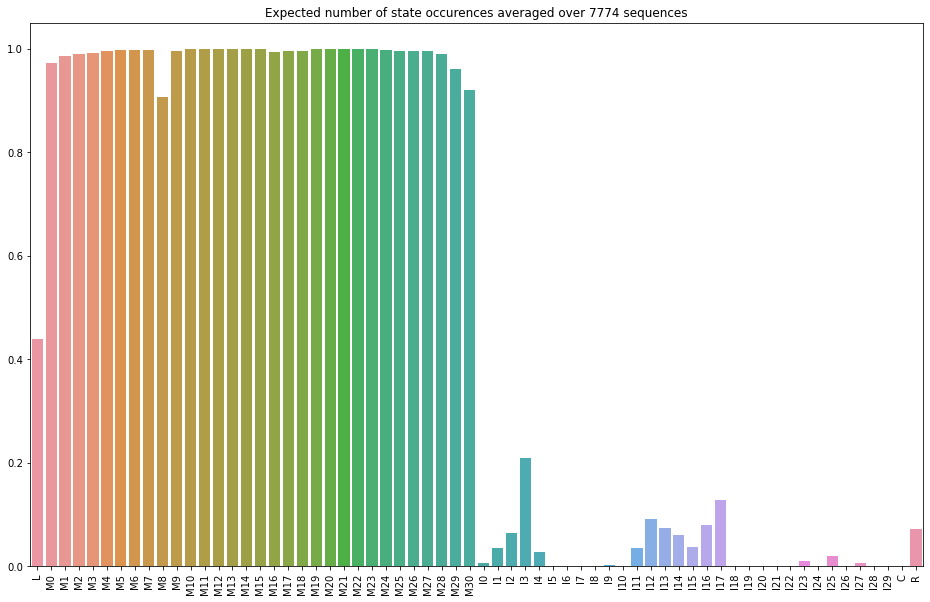

In [7]:
model_index = 0
no_terminal_state = True
f, ax = plt.subplots(1,1)
f.set_size_inches(16,10)
ax.set_title(f"Expected number of state occurences averaged over {indices.shape[0]} sequences")
num_matches = alignment.msa_hmm_layer.cell.length[model_index]
num_states = alignment.msa_hmm_layer.cell.num_states[model_index]
state_names = ["L"]+[f"M{i}" for i in range(num_matches)]+[f"I{i}" for i in range(num_matches-1)]+["C","R","T"]
sns.barplot(x=state_names[:num_states-no_terminal_state], y=p[model_index][:num_states-no_terminal_state], ax=ax)
plt.xticks(rotation=90);
plt.savefig("fig/expected_states.pdf", bbox_inches='tight')